# Analysis of ProGen2 Candidates with AI4AMP and ESMFold

This notebook loads `candidates_scored_and_folded.csv`, ranks candidates by antimicrobial probability and structural confidence, and produces basic plots and summary tables.

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

In [13]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["figure.dpi"] = 150
sns.set(style="whitegrid")

# Paths to your scored CSVs
scored_dir = "Scored"

csv_test   = os.path.join(scored_dir, "test_scored_and_folded.csv")
csv_mutant = os.path.join(scored_dir, "random_scored_and_folded.csv")
csv_tuned  = os.path.join(scored_dir, "candidates_scored_and_folded.csv")
csv_base   = os.path.join(scored_dir, "base_scored_and_folded.csv")

df_test   = pd.read_csv(csv_test)
df_mutant = pd.read_csv(csv_mutant)
df_tuned  = pd.read_csv(csv_tuned)
df_base   = pd.read_csv(csv_base)

df_test["group"]   = "Test"
df_mutant["group"] = "Mutant"
df_tuned["group"]  = "Generated"
df_base["group"]   = "BaseProGen2"

df_all = pd.concat([df_test, df_mutant, df_tuned, df_base], ignore_index=True)

In [14]:
# get Top N by AI4AMP
TOP_N = 10

def topN(df_in, n=TOP_N):
    return df_in.sort_values("ai4amp_score", ascending=False).head(n)

# violin plot by group for a specified column
def violin_plot(df_in, groups, value_col, ylabel, title):
    """
    Creates a violin plot similar to the LSSAMP figure:
    - Filled violin
    - Black outline
    - Vertical min–max lines
    - Dashed mean line
    """
    plt.figure(figsize=(5,4))
    ax = plt.gca()

    # Main violin plot
    sns.violinplot(
        data=df_in,
        x="group",
        y=value_col,
        order=groups,
        inner=None,
        cut=0,
        linewidth=1.5,
        ax=ax,
        palette="pastel"
    )

    # Black outline
    for c in ax.collections:
        c.set_edgecolor("black")
        c.set_linewidth(1.5)

    # Add vertical min–max lines and dashed mean lines
    for i, g in enumerate(groups):
        vals = df_in[df_in["group"] == g][value_col].dropna()
        if len(vals) == 0:
            continue
        x_pos = i
        vmin, vmax = vals.min(), vals.max()
        mean = vals.mean()

        # Vertical min–max
        ax.vlines(
            x_pos,
            ymin=vmin,
            ymax=vmax,
            colors="black",
            linewidth=2,
        )

        # Mean: dashed short line
        ax.hlines(
            y=mean,
            xmin=x_pos - 0.22,
            xmax=x_pos + 0.22,
            colors="black",
            linestyles="dashed",
            linewidth=2,
        )

    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def ks_stats(df, group1, group2, column):
    x = df[df["group"] == group1][column].dropna()
    y = df[df["group"] == group2][column].dropna()
    if len(x) == 0 or len(y) == 0:
        return np.nan, np.nan
    stat, p = ks_2samp(x, y)
    return stat, p

In [15]:
baseline_pairs = [
    ("Test", "Mutant"),
    ("Test", "Generated"),
    ("Mutant", "Generated"),
]

ablation_pairs = [
    ("BaseProGen2", "Generated"),
]

metrics = ["ai4amp_score", "pLDDT_mean", "PAE_mean"]

rows = []

for col in metrics:
    # Baseline
    for g1, g2 in baseline_pairs:
        ks_stat, p_val = ks_stats(df_all, g1, g2, col)
        x = df_all[df_all["group"] == g1][col].dropna()
        y = df_all[df_all["group"] == g2][col].dropna()
        rows.append({
            "metric": col,
            "group1": g1,
            "group2": g2,
            "mean_group1": x.mean() if len(x) else np.nan,
            "mean_group2": y.mean() if len(y) else np.nan,
            "KS_stat": ks_stat,
            "p_value": p_val,
        })

    # Ablation
    for g1, g2 in ablation_pairs:
        ks_stat, p_val = ks_stats(df_all, g1, g2, col)
        x = df_all[df_all["group"] == g1][col].dropna()
        y = df_all[df_all["group"] == g2][col].dropna()
        rows.append({
            "metric": col,
            "group1": g1,
            "group2": g2,
            "mean_group1": x.mean() if len(x) else np.nan,
            "mean_group2": y.mean() if len(y) else np.nan,
            "KS_stat": ks_stat,
            "p_value": p_val,
        })

stats_df = pd.DataFrame(rows)
stats_df.to_csv("metric_comparison_table.csv", index=False)
print("Saved: metric_comparison_table.csv")

Saved: metric_comparison_table.csv


In [16]:
# Baseline subset (Top 10 in each of the 3 groups)
baseline_groups = ["Test", "Mutant", "Generated"]
df_top_baseline = pd.concat(
    [topN(df_all[df_all["group"] == g]) for g in baseline_groups],
    ignore_index=True
)

# Ablation subset (Top 10 in BaseProGen2 and Generated)
ablation_groups = ["BaseProGen2", "Generated"]
df_top_ablation = pd.concat(
    [topN(df_all[df_all["group"] == g]) for g in ablation_groups],
    ignore_index=True
)

/var/folders/kz/5h8flwvd72j_pwszpzvx0gwr0000gn/T/ipykernel_7445/2103219700.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


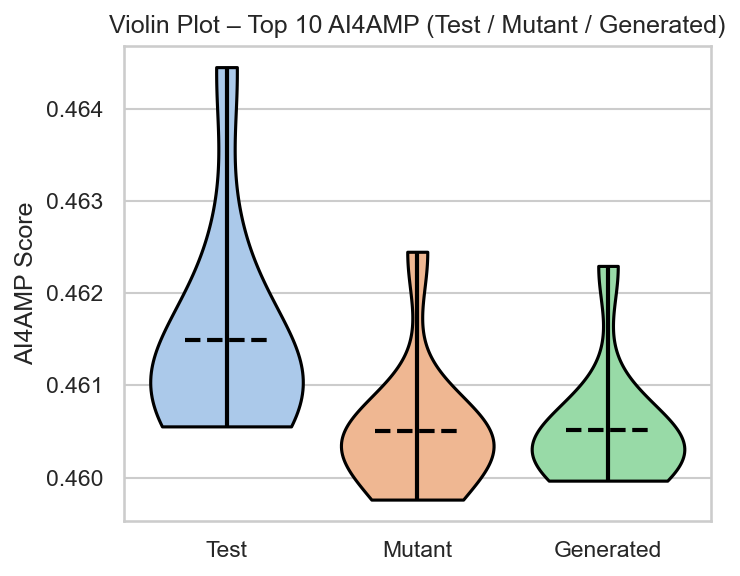

/var/folders/kz/5h8flwvd72j_pwszpzvx0gwr0000gn/T/ipykernel_7445/2103219700.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


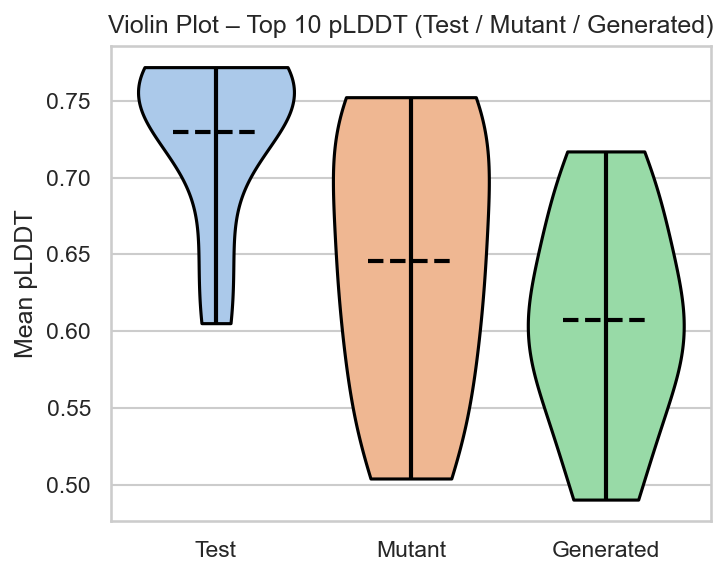

/var/folders/kz/5h8flwvd72j_pwszpzvx0gwr0000gn/T/ipykernel_7445/2103219700.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


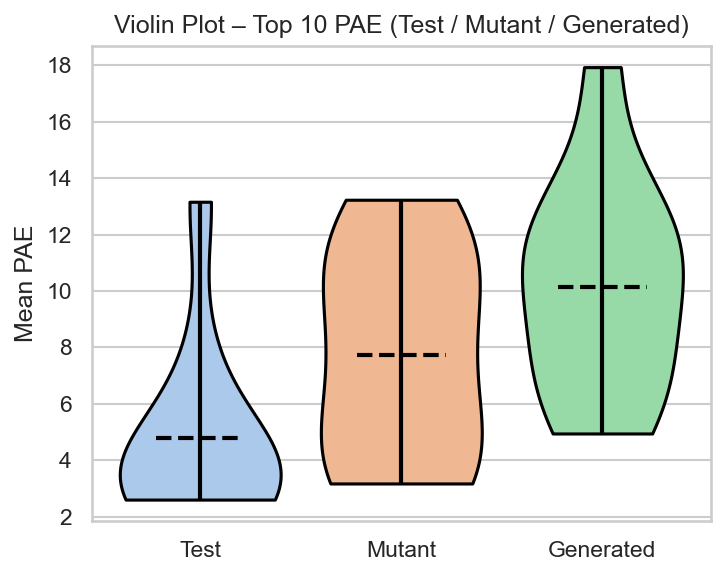

In [17]:
# BASELINE: Test vs Mutant vs Generated (Top 10 each)

# AI4AMP SCORE
violin_plot(
    df_top_baseline,
    baseline_groups,
    value_col="ai4amp_score",
    ylabel="AI4AMP Score",
    title=f"Violin Plot – Top {TOP_N} AI4AMP (Test / Mutant / Generated)"
)

# Mean pLDDT
violin_plot(
    df_top_baseline,
    baseline_groups,
    value_col="pLDDT_mean",
    ylabel="Mean pLDDT",
    title=f"Violin Plot – Top {TOP_N} pLDDT (Test / Mutant / Generated)"
)

# Mean PAE
violin_plot(
    df_top_baseline,
    baseline_groups,
    value_col="PAE_mean",
    ylabel="Mean PAE",
    title=f"Violin Plot – Top {TOP_N} PAE (Test / Mutant / Generated)"
)

/var/folders/kz/5h8flwvd72j_pwszpzvx0gwr0000gn/T/ipykernel_7445/2103219700.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


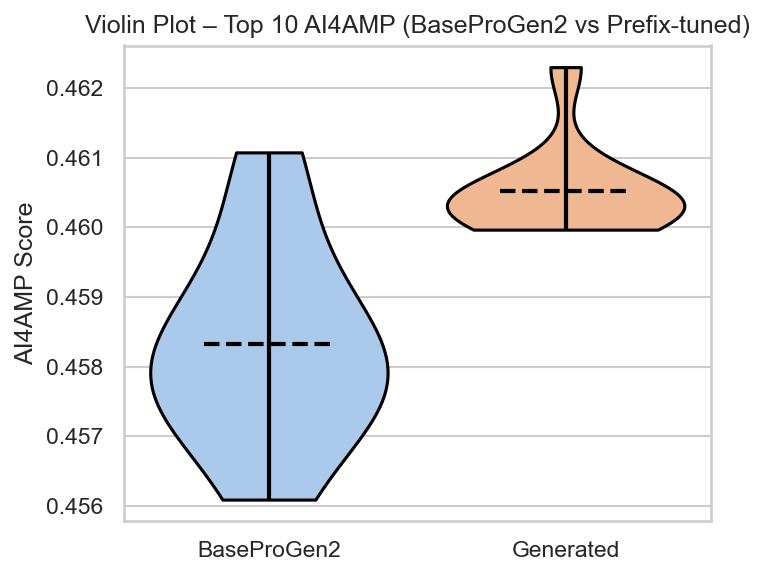

/var/folders/kz/5h8flwvd72j_pwszpzvx0gwr0000gn/T/ipykernel_7445/2103219700.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


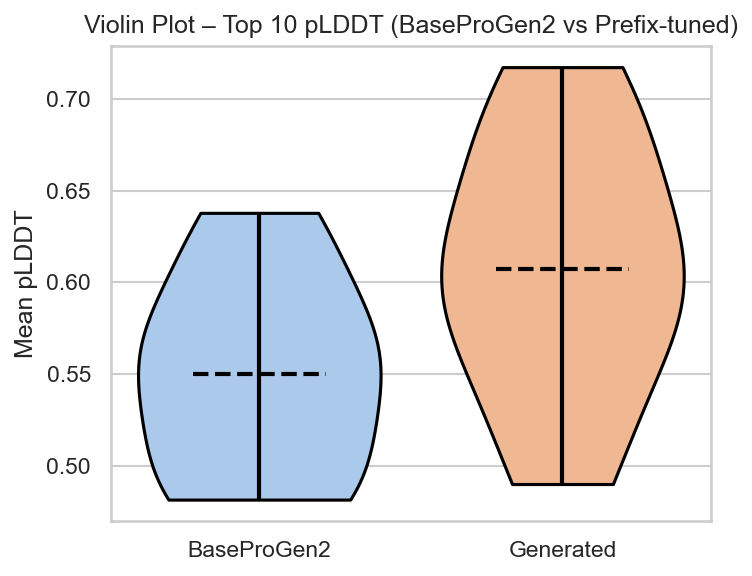

/var/folders/kz/5h8flwvd72j_pwszpzvx0gwr0000gn/T/ipykernel_7445/2103219700.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


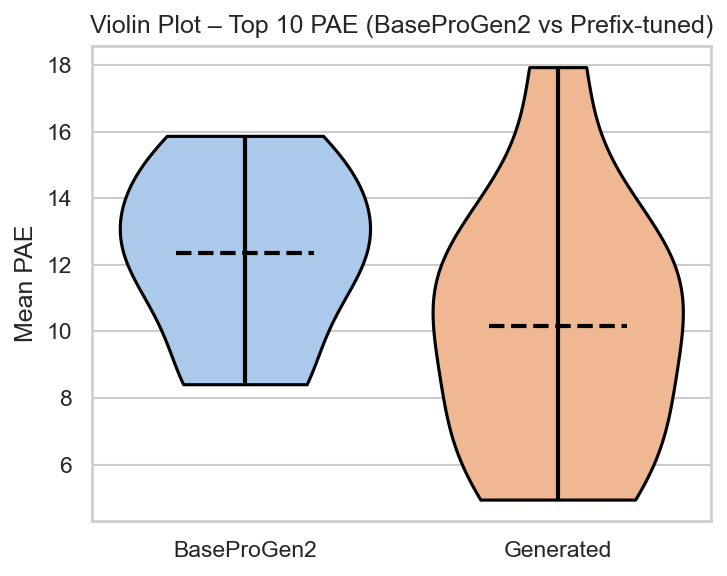

In [18]:
# ABLATION: BaseProGen2 vs Prefix-tuned (Top 10 each)

# AI4AMP SCORE
violin_plot(
    df_top_ablation,
    ablation_groups,
    value_col="ai4amp_score",
    ylabel="AI4AMP Score",
    title=f"Violin Plot – Top {TOP_N} AI4AMP (BaseProGen2 vs Prefix-tuned)"
)

# Mean pLDDT
violin_plot(
    df_top_ablation,
    ablation_groups,
    value_col="pLDDT_mean",
    ylabel="Mean pLDDT",
    title=f"Violin Plot – Top {TOP_N} pLDDT (BaseProGen2 vs Prefix-tuned)"
)

# Mean PAE
violin_plot(
    df_top_ablation,
    ablation_groups,
    value_col="PAE_mean",
    ylabel="Mean PAE",
    title=f"Violin Plot – Top {TOP_N} PAE (BaseProGen2 vs Prefix-tuned)"
)